# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import time as time

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from catboost import CatBoostRegressor, Pool

from lightgbm import LGBMRegressor

from sklearn import linear_model

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer



from sklearn.model_selection import train_test_split

In [2]:
#вариант чтобы открыть файл:
try:
    df = pd.read_csv("autos.csv")
except:
    df = pd.read_csv("/datasets/autos.csv")

In [3]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на количество столбцов и строк

In [4]:
df.shape

(354369, 16)

Таблица имеет 354369 строк и 16 столбцов.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Что мы исправим:

    - столбец DateCrawled, RegistrationYear, RegistrationMonth, DateCreated, LastSeen исправим типы данных - сделаем тип date
    
    - уберем везде верхний регистр в названии столбцах
    
    - поставим нижние пробелы между словами в названии столбцах

Изменим тип данных в столбцах DateCrawled, DateCreated, LastSeen с object на datetime64

In [6]:
df = df.astype({"DateCrawled": "datetime64[ns]"})
df = df.astype({"DateCreated": "datetime64[ns]"})
df = df.astype({"LastSeen": "datetime64[ns]"}, errors="ignore")

В остальных столбцах изменим тип данных с int64 на int32 что-бы меньше занимали места

In [7]:
df[
    [
        "Price",
        "RegistrationYear",
        "Power",
        "Kilometer",
        "RegistrationMonth",
        "NumberOfPictures",
        "PostalCode",
    ]
] = df[
    [
        "Price",
        "RegistrationYear",
        "Power",
        "Kilometer",
        "RegistrationMonth",
        "NumberOfPictures",
        "PostalCode",
    ]
].astype(
    "int32"
)

In [8]:
df.columns = (
    df.columns.str.replace(
        r"([A-Z])", r" \1").str.lower().str.replace(" ", "_").str[1:]
)

/tmp/ipykernel_27819/3300380156.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns.str.replace(


Проверим что все ОК

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int32         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int32         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int32         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int32         
 8   registration_month  354369 non-null  int32         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

 Ну вот и около 10 мегабайт освободили

#### Вывод

Данные состоят из 354369 строк и 16 столбцов, содержат типы данных datetime64, int32 и object. Если посмотреть на вывод info то мы видим пропущенные значения но их природу разберем в следующем цикле анализа.

### Исследовательский анализ данных

Проверим на отсутствие дубликатов

In [10]:
df.duplicated().sum()

4

Странно, только 4 значения посмотрим что это за дубликаты

In [11]:
df.loc[df.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Удалим дубликаты

In [12]:
df = df.drop_duplicates().reset_index(drop=True)

Проверим что дубликаты удалены

In [13]:
df.duplicated().sum()

0

Проверим данные на наличие пропущенных значений. Хотя в методе info() уже видно что пропущенных значений нет.

In [14]:
df.isna().mean().sort_values(ascending=False)

not_repaired          0.200793
vehicle_type          0.105795
fuel_type             0.092828
gearbox               0.055968
model                 0.055607
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Имеются пропущенные значения далее посмотрим на них более подробно.

---

Посмотрим на столбец **date_crawled** - дата скачивания анкеты из базы

In [15]:
df['date_crawled'].agg(['min', 'max'])

min   2016-03-05 14:06:22
max   2016-04-07 14:36:58
Name: date_crawled, dtype: datetime64[ns]

Данные выгружались в течение одного месяца

----

Посмотрим на столбец **price**

In [16]:
df['price'].agg(['min', 'max'])

min        0
max    20000
Name: price, dtype: int64

Минимальная цена равна 0 максимальная 20000.

In [17]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

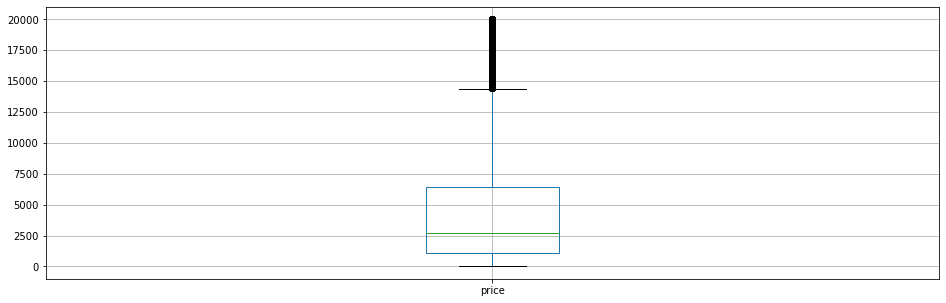

In [18]:
plt.figure(figsize=(16, 5))
df.boxplot(['price']);

In [19]:
df.loc[df['price'] == 0].head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10


Как то странно, цена машины не может быть равна 0, удалим эти данные.

In [20]:
df.loc[df['price'] == 0]['price'].count()

10772

In [21]:
df.loc[df['price'] == 0]['price'].count()/len(df)

0.030398035923412302

In [22]:
df = df.query('price > 0')

---

Просмотрим на значения в столбце **registration_year**

In [23]:
df['registration_year'].agg(['min', 'max'])

min    1000
max    9999
Name: registration_year, dtype: int64

Максимальное значения 1000, минимальное 9999, что не может быть.

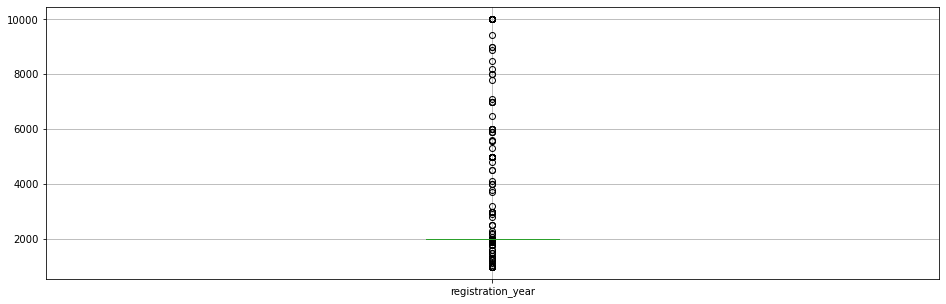

In [24]:
plt.figure(figsize=(16, 5))
df.boxplot(['registration_year']);

Итак первые номера начали регистрировать в 1899 г. Значит все что меньше мы удалим вот ссылка на статью 
[ссылка](https://www.drive2.ru/b/499040841130574252/#:~:text=Имеются%20данные%2C%20что%20первые%20автономера,столице%20Франции%20в%201893%20году)

Так опредилимся с верхней границей она будет равна самой последней дате создания анкеты в столбце DateCreated. 

In [25]:
df['date_created'].agg('max')

Timestamp('2016-04-07 00:00:00')

Уберем выбросы

In [26]:
df = df.query("registration_year >= 1899 and registration_year <= 2017")

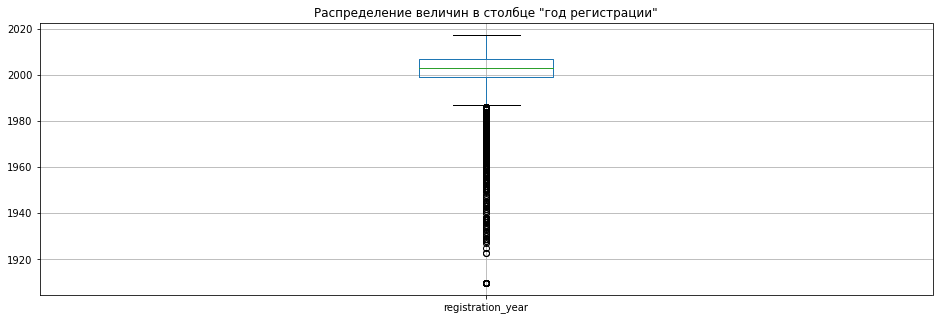

In [27]:
plt.figure(figsize=(16, 5))
plt.title('Распределение величин в столбце "год регистрации"')
df.boxplot(['registration_year']);

<AxesSubplot:title={'center':'Количество зарегистрированных автомобилей по годам'}, xlabel='Год регистрации', ylabel='Количество'>

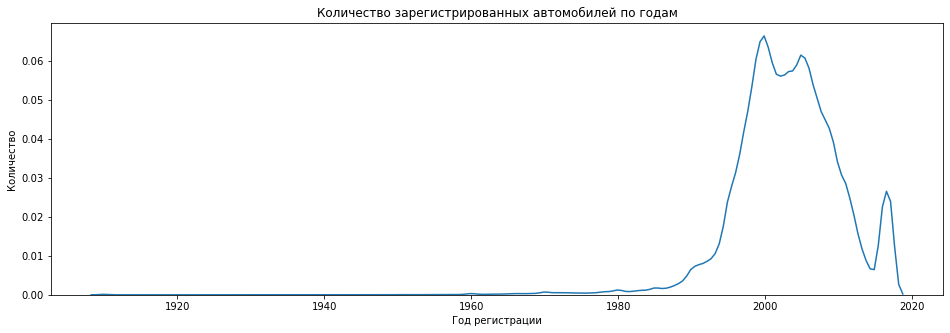

In [28]:
plt.figure(figsize=(16, 5))
plt.title('Количество зарегистрированных автомобилей по годам')
plt.ylabel("Количество")
plt.xlabel("Год регистрации")
sns.kdeplot(df['registration_year'])

Из распределения видно что пик реистрации автомобилей пришелся на 2000 - 2005 год, далее колличество зарегистрированных машин начало уменьшаться.

---

Посмотрим на столбец **gearbox**

Больше всего машин с механической коробкой передач. Посмотрим как цена автомобиля зависит от типа коробки передач.

In [29]:
df.groupby('gearbox', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
gearbox,,
auto,64390,7003.830486
manual,258473,4092.158512
NaN,16793,2512.020187


Итак мы видим, что дороже продаются машины с автоматической коробкой передач, но колличество их очень мало по сравнению с механической. Имеются пропущенные значения, удалим их, так как они составляют всего 5% от общего числа значений.

<div class="alert alert-info"> <b>Комментарий студента: </b> 

Хотел восстановить данные как ты подсказал из ссылок сверху, ничего не получилось. Я понял как заполнять пропуски если у тебя колличественные  переменные, а с категриальными так-же? Для категориальных попробывал заменить модой, но у меня ничего не получилось. Поэтому просто пропущенные значения заменил uknown. Код был такой 
    
     df['gearbox'] = df.groupby(['registration_year', 'brand', 'model'], sort=False)['brand'].apply(lambda x:x.fillna(x.mode().iloc[0])
  
</div>

In [30]:
df['gearbox'] = df['gearbox'].fillna('uknown')

---

Посмотрим на данные в столбце  **power**

In [31]:
df['power'].agg(['min', 'max'])

min        0
max    20000
Name: power, dtype: int64

Минимальная мощность равна 0 максимальная 20000 лошадинных сил.

In [32]:
df['power'].describe()

count    339656.000000
mean        111.231749
std         186.151064
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Мы тут наблюдаем опять выбросы

Мощность не может быть 20000 если это не супер автомобиль. Максимальная мощность автомобиля 1600 [Ссылка](https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire). А минимальная более 4 [Ссылка](https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html). Удалим значение где мощность больше 1600 и равна 0

In [33]:
df.query('power <= 1800 and power > 4')['power'].count()/len(df)

0.8953235037802953

In [34]:
df = df.query('power <= 1600 and power > 4')

Проверим что все ОК

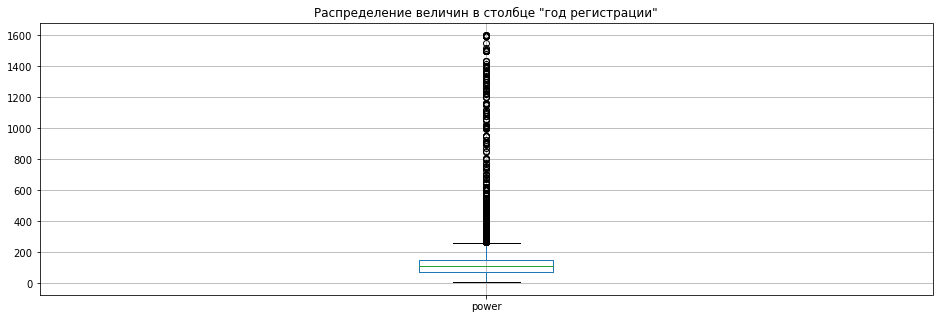

In [35]:
plt.figure(figsize=(16, 5))
plt.title('Распределение величин в столбце "год регистрации"')
df.boxplot(['power']);

In [36]:
df['power'].describe()

count    304074.000000
mean        120.947319
std          59.396276
min           5.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1600.000000
Name: power, dtype: float64

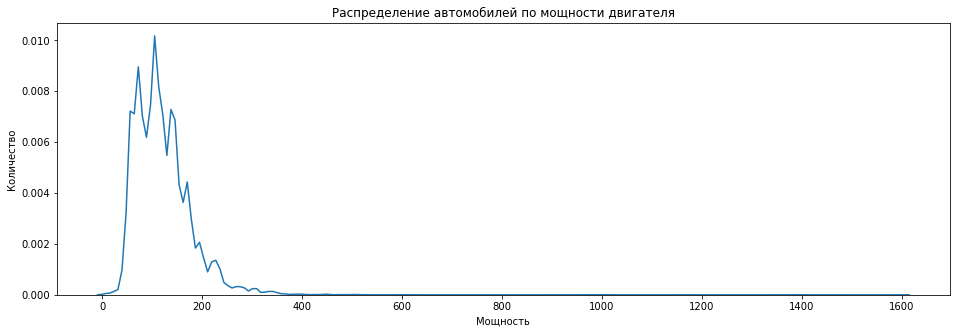

In [37]:
plt.figure(figsize=(16, 5))
plt.title('Распределение автомобилей по мощности двигателя')
plt.ylabel("Количество")
plt.xlabel("Мощность")
sns.kdeplot(df['power']);

Больше всего машин имеют диапазон в мощности между 4 и 400 лошадиными силами.

Посмотрим как цена зависит от мощности автомобиля

In [38]:
df_w = df.copy()

In [39]:
df_w['power_bin'] = pd.qcut(df_w['power'], 5)

In [40]:
df_w.groupby('power_bin',
             dropna=False)['price'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
power_bin,,
"(160.0, 1600.0]",58944,8587.701581
"(125.0, 160.0]",57700,6041.088302
"(101.0, 125.0]",63423,4631.058370
"(75.0, 101.0]",47184,3358.811991
"(4.999, 75.0]",76823,2064.875415


Посмотрим на графическую зависимость.

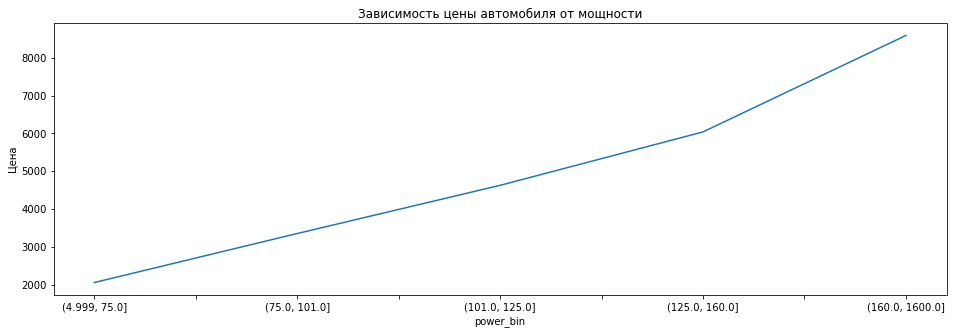

In [41]:
plt.figure(figsize=(16, 5))
plt.title("Зависимость цены автомобиля от мощности")
plt.ylabel("Цена")
df_w.groupby('power_bin', dropna=False)['price'].mean().plot();

Из графика видно что чем больше мощность автомобиля, тем больше цена. Почти прямая зависимость.

---

Посмотрим на данные в столбце  **model**

In [42]:
df.groupby('model', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
model,,
gl,12,18378.833333
glk,60,16568.350000
a5,516,15914.065891
q5,95,15789.126316
q7,188,15704.797872
...,...,...
seicento,517,869.069632
lybra,40,860.325000
move,38,706.105263


In [43]:
df.isna().mean().sort_values(ascending=False)

not_repaired          0.151420
fuel_type             0.061021
vehicle_type          0.060676
model                 0.039648
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
gearbox               0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

В столбце model присутствую пропущенные значения, я думаю это связно с тем что кто-то не захотел писать или не знал что за модель у автомобиля. Доля пропущенных значений составляет примерно 0.03. Вместо пропущенных значений напишем other. 

In [44]:
df['model'] = df['model'].fillna('other')

Цена автомобиля зависит от модели машины. Тройка топ дорогих моделей - Mercedes-Benz GL-Класс, Mercedes-Benz GLC, Audi A5

---

 Посмотрим на столбец **kilometer**

/home/vic/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


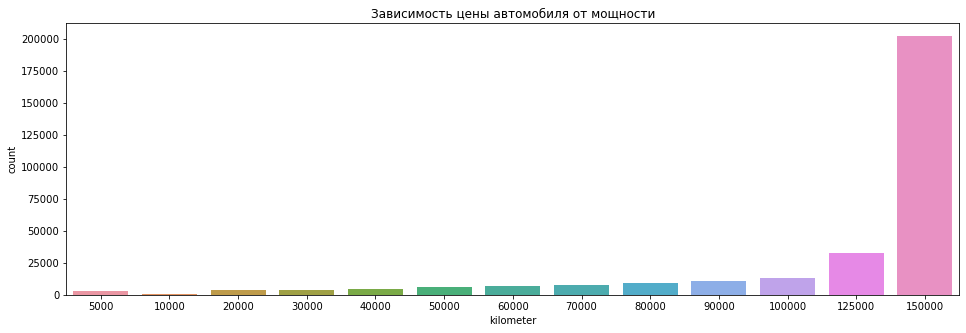

In [45]:
plt.figure(figsize=(16, 5))
plt.title("Зависимость цены автомобиля от мощности")
plt.ylabel("Мощность")
sns.countplot(df['kilometer']);

In [46]:
df['kilometer'].describe()

count    304074.000000
mean     128404.878418
std       36733.765266
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

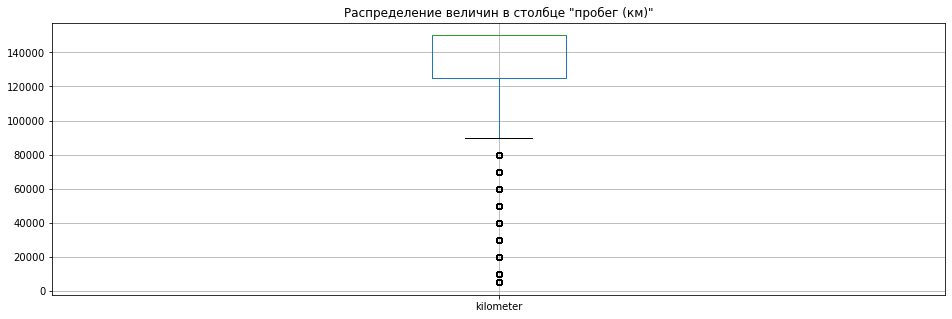

In [47]:
plt.figure(figsize=(16, 5))
plt.title('Распределение величин в столбце "пробег (км)"')
df.boxplot(['kilometer']);

Да тут распределение не очень, видно что более 50 процентов автомобилей имею пробег 150 тысяч, мне кажется это связано с работой самого приложения, может быть оно не позволяет поставить пробег больше 150 тысяч. Но работаем как есть. Плохо нельзя отследить как зависит цена автомобиля от пробега, так как почти все данные сконцентрированы около 150 тысяч.

___

Посмотрим на данные в столбце  **registration_month**

In [48]:
df.groupby('registration_month', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
registration_month,,
11,21529,5194.128013
9,21388,5153.320039
10,23457,5084.160421
7,24420,5053.621253
4,26359,5018.575174
6,28267,4980.186153
1,20624,4974.260328
8,20200,4952.565990
5,26204,4911.142764


У нас появился нулевой месяц. Более 9% значений месяца = 0, что много.
При этом в 12 месяце значений около этой же величины, а в 1 месяце более чем в 2,5 раза меньше. Распределим эти записи пропорционально доли каждого месяца по соответствующим месяцам случайным образом.

Cоздадим список с размерами "месяцев регистрации" относительно  месяца 0 и рассчитаем сколько записей из 0 месяца надо передать в каждый месяц

In [49]:
new_list = []
for i in range(1, 13):
    frac = df.query('registration_month==@i').shape[0]/(
        df.shape[0]-df.query('registration_month == 0').shape[0])
    n_size = round(df.query('registration_month == 0').shape[0]*frac)
    new_list.append(n_size)

Заменяем значения в столбце RegistrationMonth == 0  на номера месяцев с 1 по 12 пропорционально их доле.

Проверим как мы округлили

In [50]:
tmp = sum(new_list)-df.query('registration_month == 0').shape[0]
tmp

0

Иногда дельта получается не ноль а больше или меньше

Поэтому что-бы округление не довало сбой,  добавим в 12 месяц + 1

In [51]:
new_list[11] = new_list[11]-tmp
sum(new_list)-df.query('registration_month == 0').shape[0]

0

In [52]:
new = np.array(df.query('registration_month==0').index)
for month, i in enumerate(new_list):
    idx = np.random.choice(new, size=i, replace=False)
    df.loc[idx, 'registration_month'] = (month+1)
    new = new[~np.isin(new, idx)]

Проверим что все ОК

In [53]:
df.groupby('registration_month')['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
registration_month,,
11,23011,5017.832080
9,22860,4979.505424
10,25072,4916.620892
7,26101,4884.147197
4,28173,4855.950697
1,22044,4813.139448
6,30213,4809.011651
8,21590,4782.619731
5,28008,4744.765746


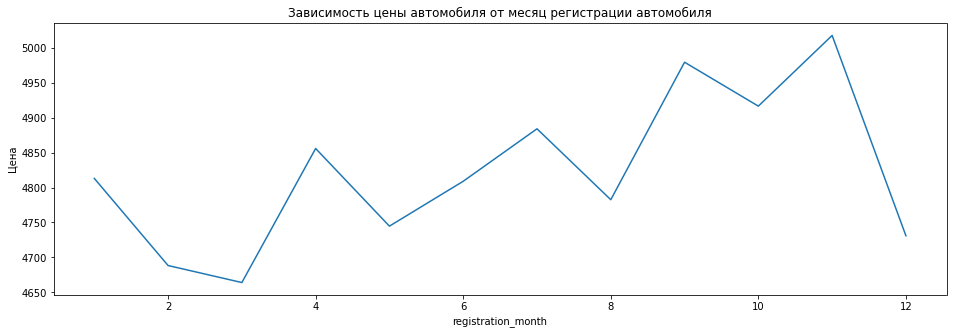

In [54]:
plt.figure(figsize=(16, 5))
plt.title('Зависимость цены автомобиля от месяц регистрации автомобиля')
plt.ylabel('Цена')
df.groupby('registration_month', dropna=False)['price'].mean().plot();

Мы видим что есть некоторая сезонность в ценах на автомобиль.

---

 Посмотрим на столбец **fuel_type**

In [55]:
df.groupby('fuel_type', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
fuel_type,,
hybrid,205,10090.985366
electric,71,7652.845070
gasoline,89070,6926.604839
cng,496,4669.423387
lpg,4763,4254.935755
petrol,190825,4036.748974
other,89,3144.516854
NaN,18555,2848.425007


Мы видим что самые дорогие машины - гибриды, на втором месте электро и на третьем бензиновые.

/home/vic/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


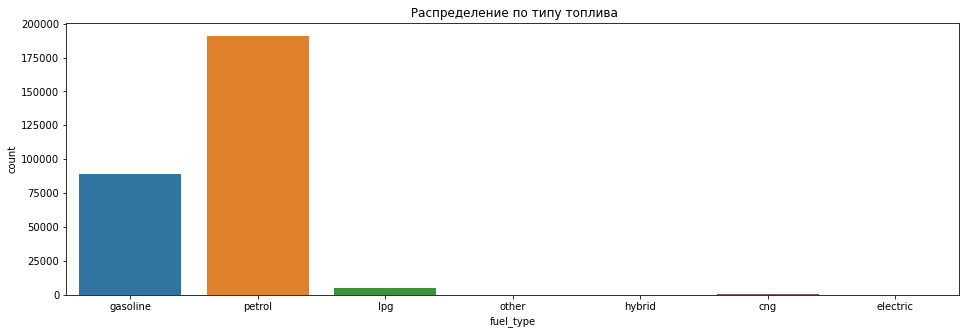

In [56]:
plt.figure(figsize=(16, 5))
plt.title(" Распределение по типу топлива")
plt.ylabel("Колличество")
sns.countplot(df['fuel_type']);

Я нашел что gasoline и gasoline это одно и тоже [Ссылка](https://www.differencebetween.info/difference-between-petrol-and-gasoline). Объединим эти значения.

In [57]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

Пропущенные значения удалим.

In [58]:
df = df.dropna(subset=['fuel_type'])

----

Посмотрим на данные в столбце  **brand**

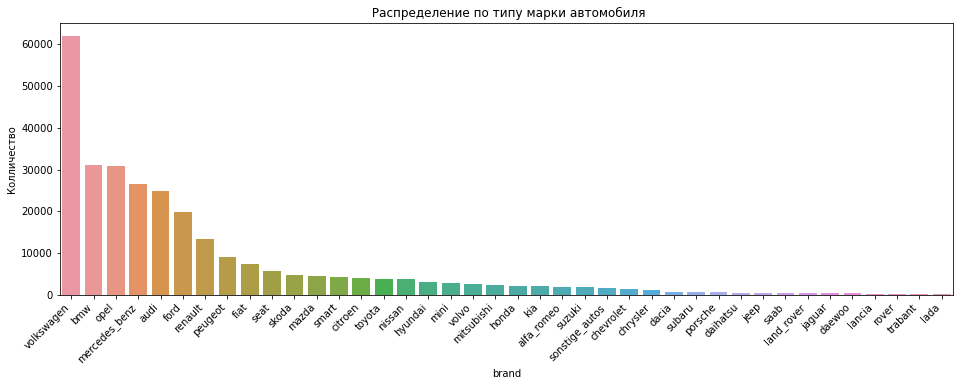

In [59]:
# сгруппируем данные
df_new = df.pivot_table(
    index="brand", values="price", aggfunc="count"
).sort_values(by="price", ascending=False)

plt.figure(figsize=(16, 5))
ax = sns.barplot(x=df_new.index, y=df_new["price"])
plt.title(" Распределение по типу марки автомобиля")
plt.ylabel("Колличество")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right');

Первые три места по колличеству продаж взяли WV, BMW, opel.

In [60]:
df.groupby('brand', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
brand,,
porsche,608,12332.639803
mini,2946,9239.346232
land_rover,454,9141.808370
sonstige_autos,1708,7782.900468
jeep,559,7664.354204
jaguar,426,7204.366197
audi,24791,6828.885362
bmw,31104,6709.365162
mercedes_benz,26617,6390.696172


Мы видим что цена автомобиля зависит от марки автомобиля.

____

Посмотрим на ячейку **not_repaired**

In [61]:
df.groupby('not_repaired', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
not_repaired,,
no,219547,5584.155725
NaN,38909,3255.947930
yes,27063,2219.604626


 Мы видим что цена продажи автомобиля зависит от того была ли машина в ремонте или нет. Причем разница почти в два раза. Имеются пропущенные значения, скорее всего это связано с тем, что Nan означает тоже самое, что если автомобиль не ремонтировался. Поэтому заменим пропущенные значения "no".  

In [62]:
df['not_repaired'] = df['not_repaired'].fillna('other')

----

Посмотрим на столбец **date_created**

In [63]:
df['date_created'].agg(['min', 'max'])

min   2015-03-20
max   2016-04-07
Name: date_created, dtype: datetime64[ns]

Обьъявления создавались с 2015 по 2016 год.

---

Посмотрим на столбец  **number_of_pictures**

In [64]:
df['number_of_pictures'].value_counts(normalize=False)

0    285519
Name: number_of_pictures, dtype: int64

Данный столбец имеет только одно значение 0 - значит фотографии в приложение на загружались. Не забудем удалить при обучении модели.

---

Посмотрим на столбце **postal_code**

In [65]:
df['postal_code'].value_counts(normalize=False).head(5)

10115    799
65428    495
60311    257
66333    256
78224    241
Name: postal_code, dtype: int64

In [66]:
df.shape

(285519, 16)

Мы имеем всего 8090 почтовых кодов. Можно  на основании этих данных составить карту с иконографикой от куда автомобили. Так например Postal Code 10115 это код Берлина 797 автомобилей от туда.

Посмотрим на столбец **last_seen**

In [67]:
df['last_seen'].agg(['min', 'max'])

min   2016-03-05 14:15:16
max   2016-04-07 14:58:51
Name: last_seen, dtype: datetime64[ns]

Дата последней активности пользователя данные представлены с 3 мая по 4 июля 2022 г.

---

Посмотрим на последний столбец **vehicle_type**

In [68]:
df.groupby('vehicle_type', dropna=False)['price'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
vehicle_type,,
suv,10695,9423.578401
convertible,18182,7123.147949
coupe,14081,6446.520062
bus,25567,5792.796183
wagon,56835,5259.728213
sedan,80208,5054.284822
other,2289,4045.362604
NaN,10820,2998.840481
small,66842,2955.108166


Мы видим что цена автомобиля зависит от типа транспортного средства. На первом месте идет внедорожник, дальше кабриолет, и потом купе. Пропущенные значения удалим.

<div class="alert alert-info"> <b>Комментарий студента: </b> Пропущенны значения заменим  на класс other.</div>

<div class="alert alert-success">

<h2> Комментарий ревьюера 2 итерация <a class="tocSkip"> </h2>

Хорошо

In [69]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

### Вывод

1. Данные выгружались в течение одного месяца.
2. Минимальная цена за автомобиль 1 максимальная 20 тысяч. 75 процентов автомобилей стоя меньше чем 7299.
3. Цена автомобиля зависит от типа транспортного средства. На первом месте по цене идет внедорожник, дальше кабриолет, и потом купе.
3. Пик регистрации автомобилей пришелся на 2000 - 2005 год, далее количество зарегистрированных машин начало уменьшаться. Мы установили границы - нижняя 1899 год, верхняя 2016 год. Обоснования представлены выше.
4. Дороже продаются машины с автоматической коробкой передач, но количество их очень мало по сравнению с механической.
5. Чем больше мощность автомобиля, тем больше цена. Мощность большинства автомобилей находится в диапазоне от 4 до 400 лошадиных сил.
6. Цена автомобиля зависит от модели машины. Тройка топ дорогих моделей - Mercedes-Benz GL-Класс, Mercedes-Benz GLC, Audi A5.
7. Более 50 процентов автомобилей имею пробег 150 тысяч, наверное это связано с работой самого приложения, может быть оно не позволяет поставить пробег больше 150 тысяч.
8. Цена автомобиля зависит от месяца регистрации автомобиля. Самая низкая цена в феврале и марте.
9. Цена автомобиля зависит от типа топлива -  самые дорогие машины - гибриды, на втором месте электро и на третьем бензиновые.
10. Цена автомобиля зависит от марки автомобиля. Топ три porshe, mini, land_rower.
11. Цена продажи автомобиля зависит от того была ли машина в ремонте или нет.  Разница в цене между небитой и битой машиной почти в два раза.
12. Фотографии в приложение на загружались.
13. Имеется всего 8090 почтовых кодов.
14. Цена автомобиля зависит от типа транспортного средства. На первом месте идет внедорожник, дальше кабриолет, и потом купе.

## Обучение моделей

Составим план обучения моделей.

   1. Делим на признаки и таргет.
   2. Отмасштабируем признаки.
   3. Обучим следующие модели:
          Линейные модели (Линейная регрессия, Ridge регрессия, Lasso регрессия) + Decision Tree
          Ансамблевые методы регрессии (Random forest regressor, GradientBoostingRegressor)
          Иттеративные модели (Lightgbm, XGBoost, Catboost)
       
   3. 'RMSE','Learning time','Predict time','Model'

Отмасштабируем признаки это нам понадобится для моделей линейной регрессии. Скопируем датасет, будем работать с двумя, одни данные мы отмасштабировали, для линейной регрессии, вторые оставим как есть, для ансамблевой и интерравтивной модели.

In [70]:
def training_time(feature_union, model, features_train, target_train):
    pipeline = Pipeline([("preprocessing", feature_union), ("modelling", model)])
    start = time.time()
    model = pipeline.fit(features_train, target_train)
    stop = time.time()
    time_traiding = stop - start
    return time_traiding, model

In [71]:
def predict_time(model, features_validate):
    start = time.time()
    predict = model.predict(features_validate)
    stop = time.time()
    time_predict = stop - start
    return time_predict, predict

А теперь функцию которая будет в наш Df добавлять данные.

In [72]:
def result_metrics(rmse, time_traiding, time_predict, model_name, df_result):
    df_result.loc[model_name, 'rmse'] = rmse
    df_result.loc[model_name, 'training_time'] = time_traiding
    df_result.loc[model_name, 'predict_time'] = time_predict
    return df_result

Ну и создадим Df куда будем складывать результаты.

In [73]:
df_result = pd.DataFrame(columns=['rmse', 'training_time', 'predict_time'])
df_result

,rmse,training_time,predict_time


Логика следующая: 
    
1. Разделим выборку на тестовую и общую тренировочную, а общую тренировочную еще на малую тренировочную и валлидационную.
    
2. Показатель RMSE будем получать с помощью cross_val на общей - всей тренировочной выборки, до того как мы  разделим ее на валлидационную.
    
3. На малой тренировочной выборке (малой то-есть которая получилась делением всей тренировочной выборки на малую тренировочную и валлидационную выборку мы обучим модель и замерим время обучения модели.
    
4. На валлидационной выборке мы замерим время предсказания модели.
    
5. На основании полученных выше показателей мы выберем лучшую модель и посмотрим как она себя ведет на тестовой выборке.
</div>

### Линейные модели

In [74]:
to_dummies = ['vehicle_type', 'gearbox',
                 'model', 'fuel_type', 'brand', 'not_repaired']

In [75]:
numerical = ['registration_year', 'power', 'kilometer',
             'registration_month', 'postal_code']

In [76]:
target = df['price']
features = df.drop(
    ['date_crawled', 'price', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

In [77]:
features_df_train, features_test, target_df_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [78]:
features_train, features_validate, target_train, target_validate  = train_test_split(
    features_df_train, target_df_train, test_size=0.2, random_state=12345)

Кадировал переменные через Pipeline.

In [79]:
# Объявляем scaler и OneHotEncoder() для числовых и категориальных переменных соответственно
scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [80]:
# Делаем pipeline для числовых переменных датасета
numerical_selector = FunctionTransformer(lambda df: df[numerical], validate=False)
numerical_preprocessor = Pipeline([("numerical_selector", numerical_selector), ("scaling", scaler)])
# Делаем pipeline для категориальных переменных датасета
dummy_selector = FunctionTransformer(lambda df: df[to_dummies], validate=False)
dummy_preprocessor = Pipeline([("dummy_selector", dummy_selector), ("ohe", ohe)])
# Объединяем созданные выше pipeline в один с помощью функции FeatureUnion
feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
("dummy_preprocessor", dummy_preprocessor)])

#### Линейная регрессия 

In [81]:
LR_training_time, LR_model = training_time(feature_union,
    linear_model.LinearRegression(), features_train, target_train)
LR_predict_time, LR_predict = predict_time(LR_model, features_validate)
LR_rmse = np.sqrt(mean_squared_error(target_validate, LR_predict))
result_metrics(LR_rmse, LR_training_time, LR_predict_time, 'Linear regression', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667


 <div class="alert alert-info"> <b>Комментарий студента: </b> Использовал только тренировочную выборку для выбора лучшей модели.</div>

<div class="alert alert-success">

<h2> Комментарий ревьюера 2 итерация <a class="tocSkip"> </h2>

Плюс

Получили значения, посмотрим еще на несколько моделей линейной регрессии.

#### Lasso регрессия

Метод регрессии лассо (LASSO, Least Absolute Shrinkage and Selection Operator) — это вариация линейной регрессии, специально адаптированная для данных, которые демонстрируют сильную мультиколлинеарность (то есть сильную корреляцию признаков друг с другом), как раз у нас присутствуют такие данные.


In [82]:
lasso_training_time, lasso_model = training_time(feature_union,
    linear_model.LassoCV(), features_train, target_train)
lasso_predict_time, lasso_predict = predict_time(
    lasso_model, features_validate)
lasso_rmse = np.sqrt(mean_squared_error(target_validate, lasso_predict))
result_metrics(lasso_rmse, lasso_training_time, lasso_predict_time,
               'Lasso regression', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434


Результат получился хуже.

#### Гребневая регрессия (ридж-регрессия)

Гребневая регрессия или ридж-регрессия очень похожа на регрессию LASSO в том, что она применяет сжатие. Однако самое большое различие между ними в том, что гребневая регрессия использует регуляризацию L2, то есть ни один из коэффициентов не становится нулевым, как это происходит в регрессии LASSO. Вместо этого коэффициенты всё больше приближаются к нулю, но не имеют большого стимула достичь его из-за природы регуляризации L2.

In [83]:
Ridge_training_time, Ridge_model = training_time(feature_union, linear_model.RidgeCV(
    alphas=np.logspace(1, 5, 13)), features_train, target_train)
Ridge_predict_time, Ridge_predict = predict_time(Ridge_model, features_validate)
Ridge_rmse = np.sqrt(mean_squared_error(target_validate, Ridge_predict))
result_metrics(Ridge_rmse, Ridge_training_time, Ridge_predict_time,
               'Ridge regression', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589


Установили диапозон alphas  равномерно распределенный по логарифмической шкале внутри диапозона от 1 до 5

#### Регрессия ElasticNet

ElasticNet стремится объединить лучшее из гребневой регрессии и регрессии лассо, комбинируя регуляризацию L1 и L2.

In [84]:
ElasticNet_training_time, ElasticNet_model = training_time(feature_union,
    linear_model.ElasticNetCV(), features_train, target_train)
ElasticNet_predict_time, ElasticNet_predict = predict_time(ElasticNet_model, features_validate)
ElasticNet_rmse = np.sqrt(mean_squared_error(target_validate, ElasticNet_predict))
result_metrics(ElasticNet_rmse, ElasticNet_training_time, ElasticNet_predict_time,
               'ElasticNet regression', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706


#### DecisionTreeRegressor

In [85]:
DecisionTreeRegressor_training_time, DecisionTreeRegressor_model = training_time(feature_union,
    DecisionTreeRegressor(), features_train, target_train)
DecisionTreeRegressor_predict_time, DecisionTreeRegressor_predict = predict_time(
    DecisionTreeRegressor_model, features_validate)
DecisionTreeRegressor_rmse = np.sqrt(mean_squared_error(
    target_validate, DecisionTreeRegressor_predict))
result_metrics(DecisionTreeRegressor_rmse, DecisionTreeRegressor_training_time,
               DecisionTreeRegressor_predict_time, 'Decision Tree Regressor', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699


#### Вывод

Из результатов видно, что лучше всего по показателю rmse показала себя **Деревья решений** на втором месте **Linear regression** и на третьем месте **Ridge regression**, в тоже время  по такому показателю как время обучения на первом месте Linear regression а время предсказания - Ridge regression.

### Ансамблевые методы регрессии

Тут категориальные переменные кодировал OrdinalEncoding.

In [86]:
# Объявляем scaler и OneHotEncoder() для числовых и категориальных переменных соответственно
scaler = MinMaxScaler()
ohe = OrdinalEncoder()

In [87]:
# Делаем pipeline для числовых переменных датасета
numerical_selector = FunctionTransformer(lambda df: df[numerical], validate=False)
numerical_preprocessor = Pipeline([("numerical_selector", numerical_selector), ("scaling", scaler)])
# Делаем pipeline для категориальных переменных датасета
dummy_selector = FunctionTransformer(lambda df: df[to_dummies], validate=False)
dummy_preprocessor = Pipeline([("dummy_selector", dummy_selector), ("ohe", ohe)])
# Объединяем созданные выше pipeline в один с помощью функции FeatureUnion
feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
("dummy_preprocessor", dummy_preprocessor)])

#### Random forest regressor

In [88]:
RF_training_time, RF_model = training_time(feature_union, RandomForestRegressor(
    n_estimators=20, random_state=12345), features_train, target_train)
RF_predict_time, RF_predict = predict_time(RF_model, features_validate)
RF_rmse = np.sqrt(mean_squared_error(target_validate, RF_predict))
result_metrics(RF_rmse, RF_training_time, RF_predict_time, 'Random forest regressor', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755


#### Gradient Boosting Regressor

In [89]:
GB_training_time, GB_model = training_time(feature_union, GradientBoostingRegressor(
    n_estimators=100), features_train, target_train)
GB_predict_time, GB_predict = predict_time(
    GB_model, features_validate)
GB_rmse = np.sqrt(mean_squared_error(target_validate, GB_predict))
result_metrics(GB_rmse, GB_training_time,GB_predict_time,
               'Gradient Boosting Regressor', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755
Gradient Boosting Regressor,1962.221118,37.565302,0.147915


Итак среди Ансамблевых методов регрессии на первом месте **Случайный лес**.

### Иттеративные модели


In [90]:
for c in to_dummies:
    df[c] = df[c].astype('category')

In [91]:
target = df['price']
features = df.drop(
    ['date_crawled', 'price', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

In [92]:
features_df_train, features_test, target_df_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [93]:
features_train, features_validate, target_train, target_validate  = train_test_split(
    features_df_train, target_df_train, test_size=0.2, random_state=12345)

In [94]:
target = df['price']
features = df.drop(
    ['date_crawled', 'price', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

features_df_train, features_test, target_df_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train, features_validate, target_train, target_validate  = train_test_split(
    features_df_train, target_df_train, test_size=0.2, random_state=12345)

#### Lightgbm

In [95]:
def training_time(model, features_train, target_train):
    start = time.time()
    model = model.fit(features_train, target_train)
    stop = time.time()
    time_traiding = stop - start
    return time_traiding, model

In [96]:
lgb_training_time, lgb_model = training_time(
    LGBMRegressor(categorical_feature= to_dummies, random_state=12345), 
    features_train, target_train)
lgb_predict_time, lgb_predict = predict_time(lgb_model, features_validate)
lgb_rmse = np.sqrt(mean_squared_error(target_validate, lgb_predict))
result_metrics(lgb_rmse, lgb_training_time, lgb_predict_time, 
               'Light Gradient Boosted Machine', df_result)

/home/vic/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/home/vic/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309


 #### XGBoost

In [97]:
def training_time(feature_union, model, features_train, target_train):
    pipeline = Pipeline([("preprocessing", feature_union), ("modelling", model)])
    start = time.time()
    model = pipeline.fit(features_train, target_train)
    stop = time.time()
    time_traiding = stop - start
    return time_traiding, model

In [98]:
xgbr_training_time, xgbr_model = training_time(feature_union,
    xgb.XGBRegressor(random_state=12345),features_train, target_train)
xgbr_predict_time, xgbr_predict = predict_time(xgbr_model, features_validate)
xgbr_rmse = np.sqrt(mean_squared_error(target_validate, xgbr_predict))
result_metrics(xgbr_rmse, xgbr_training_time, xgbr_predict_time, 'XGBoost', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309
XGBoost,1643.078731,20.924968,0.238576


 #### CatBoost

In [99]:
def training_time(model, features_train, target_train):
    start = time.time()
    model = model.fit(features_train, target_train)
    stop = time.time()
    time_traiding = stop - start
    return time_traiding, model

In [100]:
cb_training_time, cb_model = training_time(CatBoostRegressor(
    loss_function='RMSE', n_estimators=100, silent=True, cat_features=to_dummies), 
    features_train, target_train)
cb_predict_time, cb_predict = predict_time(cb_model, features_validate)
cb_rmse = np.sqrt(mean_squared_error(target_validate, cb_predict))
result_metrics(cb_rmse, cb_training_time, cb_predict_time, 'Catboost', df_result)

,rmse,training_time,predict_time
Linear regression,2711.634286,11.846433,0.414667
Lasso regression,2728.053897,47.038173,0.342434
Ridge regression,2714.886593,35.211189,0.42589
ElasticNet regression,4240.177422,24.62764,0.361706
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309
XGBoost,1643.078731,20.924968,0.238576
Catboost,1690.86639,6.459947,0.042929


## Анализ моделей

Посмотрим на показатель RMSE

In [101]:
df_result.sort_values(by='rmse')

,rmse,training_time,predict_time
Random forest regressor,1625.153211,22.893535,0.646755
XGBoost,1643.078731,20.924968,0.238576
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309
Catboost,1690.86639,6.459947,0.042929
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Decision Tree Regressor,2082.102453,23.031683,0.483699
Linear regression,2711.634286,11.846433,0.414667
Ridge regression,2714.886593,35.211189,0.42589
Lasso regression,2728.053897,47.038173,0.342434
ElasticNet regression,4240.177422,24.62764,0.361706


По показателю  RMSE лучше всех себя показали модели в порядке убывания - "Случайный лес", 'XGBoost' и 'Catboost'

Посмотрим теперь на время обучения

In [102]:
df_result.sort_values(by='training_time')

,rmse,training_time,predict_time
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309
Catboost,1690.86639,6.459947,0.042929
Linear regression,2711.634286,11.846433,0.414667
XGBoost,1643.078731,20.924968,0.238576
Random forest regressor,1625.153211,22.893535,0.646755
Decision Tree Regressor,2082.102453,23.031683,0.483699
ElasticNet regression,4240.177422,24.62764,0.361706
Ridge regression,2714.886593,35.211189,0.42589
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Lasso regression,2728.053897,47.038173,0.342434


По показателю время обучения модели - Light Gradient Boosted Machine', 'Catboost', 'Decision Tree Regressor'.

Посмотрим теперь на время предсказания

In [103]:
df_result.sort_values(by='predict_time')

,rmse,training_time,predict_time
Catboost,1690.86639,6.459947,0.042929
Gradient Boosting Regressor,1962.221118,37.565302,0.147915
Light Gradient Boosted Machine,1644.362057,1.523028,0.162309
XGBoost,1643.078731,20.924968,0.238576
Lasso regression,2728.053897,47.038173,0.342434
ElasticNet regression,4240.177422,24.62764,0.361706
Linear regression,2711.634286,11.846433,0.414667
Ridge regression,2714.886593,35.211189,0.42589
Decision Tree Regressor,2082.102453,23.031683,0.483699
Random forest regressor,1625.153211,22.893535,0.646755


По показателю время обучения модели - 'Catboost', 'XGBoost', 'Gradient Boosting Regressor'.

Посмотрим как RMSE зависит от времени предсказания

Добавим новый столбец с названием модели

In [104]:
df_result['name_model'] = df_result.index

Посмотрим как RMSE зависит от время обучения модели.

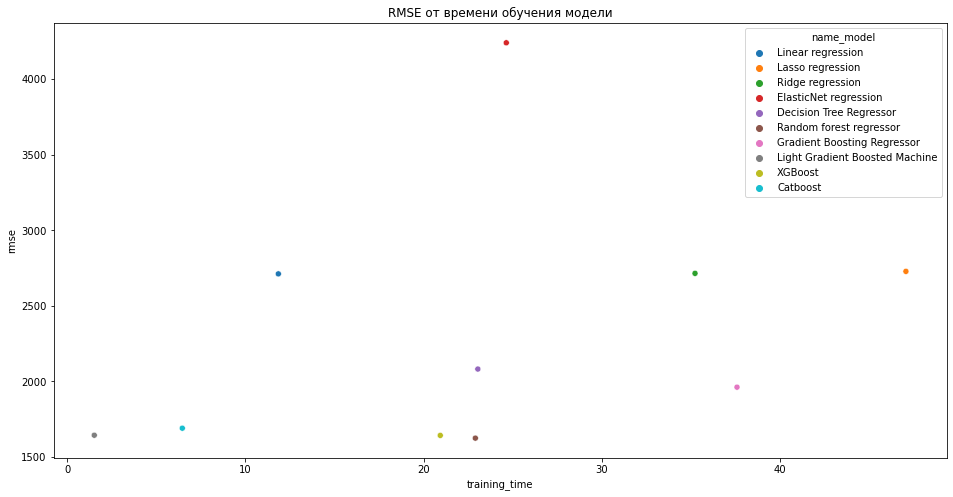

In [105]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=df_result, x='training_time', y='rmse', hue='name_model')
plt.title('RMSE от времени обучения модели');

Закономерности я не вижу, так "Случайный лес" обучается долго, 'XGBoost' в два раза быстрее но показатель RMSE у моделей одинаковый, а "Градиентный бустинг" и 'Catboost' обучаюся очень мало по времени но по показателю RMSE они сопоставимы с моделями обучающимеся в два и в три раза больше.

Посмотрим как RMSE зависит от время предсказания модели.

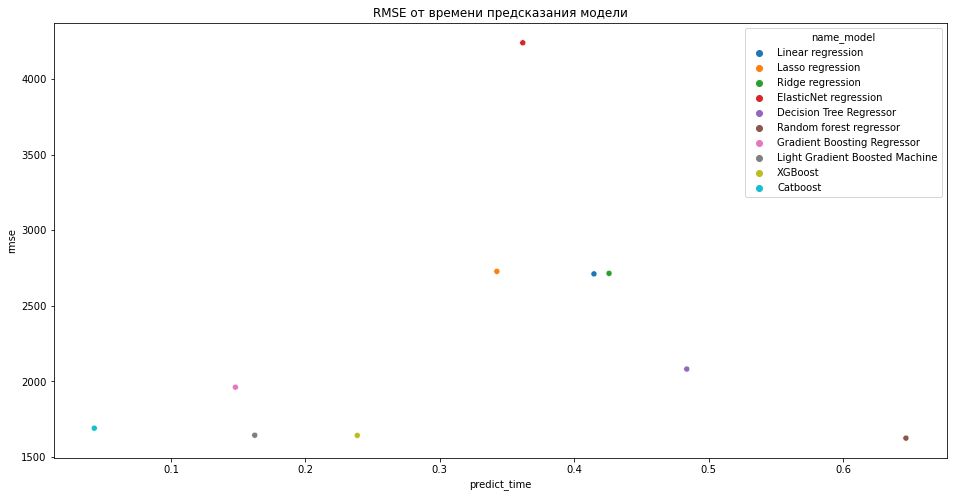

In [106]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=df_result, x='predict_time', y='rmse', hue='name_model')
plt.title('RMSE от времени предсказания модели');


По времени предсказания модели Catboost со значительным отрывом занимает первое место.

### Вывод

1. По показателю  RMSE луше всех себя показали модели в порядке убывания - "Случайный лес", 'XGBoost' и 'Catboost'
    
2. По показателю время обучения модели - 'Light Gradient Boosted Machine', 'Catboost', 'Decision Tree Regressor'.
    
3. По показателю время предсказание - 'Catboost', 'XGBoost', 'Gradient Boosting Regressor'
    
4. RMSE не зависит от времени обучения и времени предсказания модели.

## Выбор оптимальной модели

Проведя анализ показателей эффективности модели, оптимальная модель - Catboost. Во первых Catboost обучает модель в пять раз быстрее, а для больших данных это плюс. Во вторых по показателю RMSE Catboost хуже топ двух всего на 73. Посмотрим как ведет себя модель на тестововой выборке.

In [107]:
cb_predict_time, cb_predict = predict_time(cb_model, features_test)
cb_rmse = np.sqrt(mean_squared_error(target_test, cb_predict))
print(f'Время предсказания модели {cb_predict_time}, RMSE={cb_rmse}')

Время предсказания модели 0.12197017669677734, RMSE=1670.169811719665


Наша модель показала лучший результат по RMSE чем на обучающей выборке, но время предсказания получилось в два раза больше чем время оучения.